<a href="https://colab.research.google.com/github/deffinpurnama/UAS-DeepLearning/blob/main/UAS_DeepLearning_Deffin_Purnama_Noer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Get Data**

In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
import os

In [2]:
# Get Data
try:
    import google.colab
    IN_COLAB = True
    print("Installing the required modules")
    #!pip install --upgrade namaModuleYangDiperlukan
    !mkdir -p data
    !wget -P data/ https://raw.githubusercontent.com/deffinpurnama/UAS-DeepLearning/main/tweets-bm.csv
    data = pd.read_csv('data/tweets-bm.csv') # Running in Google Colab
except:
    IN_COLAB = False
    print("Running the code locally, please make sure all the python module versions agree with colab environment and all data/assets downloaded")
    data = pd.read_csv('data/tweets-bm.csv') # Running Locally

# Menampilkan tiga baris pertama
data.head(3)

Installing the required modules
--2024-07-20 20:08:30--  https://raw.githubusercontent.com/deffinpurnama/UAS-DeepLearning/main/tweets-bm.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 948979 (927K) [text/plain]
Saving to: ‘data/tweets-bm.csv.1’

tweets-bm.csv.1     100%[===================>] 926.74K  --.-KB/s    in 0.02s   

2024-07-20 20:08:30 (39.8 MB/s) - ‘data/tweets-bm.csv.1’ saved [948979/948979]



,id_,created_at,tweetID,tweet,username,id_str,name,entity,commentcount,likes,retweets,quotes,replies,sentiment,bidang,gender,link,imageUrl
0,1,2023-01-01 13:50:44,1609547674893844481,"Hallo, sobat Nedutase Lepas Sambut Kepala SMK ...",TangselSmkn2,1414792059257380864,SMKN2Tangsel,Daihatsu,0.0,NaN,NaN,NaN,1,NaN,NaN,NaN,https://twitter.com/TangselSmkn2,https://pbs.twimg.com/profile_images/155974970...
1,2,2023-01-01 11:00:01,1609504712012795907,Shin Tae-yong selaku pelatih kepala Timnas Ind...,PSSI,2363027508,PSSI,Mitsubishi,31.0,1837302.0,159.0,24686.0,31,NaN,NaN,NaN,https://twitter.com/PSSI/status/16095047120127...,https://pbs.twimg.com/media/FlYVvBCaUAA-LHy.jp...
2,3,2023-01-02 09:41:59,1609847465347543042,SUZUKI XL 7 Jawabannya! Tampilan eksterior Suz...,GampongSuzuki,971377286,Gampong Suzuki,Suzuki,0.0,140.0,72.0,1510.0,0,NaN,NaN,NaN,https://twitter.com/GampongSuzuki/status/16098...,https://pbs.twimg.com/media/FldTuxJakAQTrqR.jp...


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2124 entries, 0 to 2123
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id_           2124 non-null   int64  
 1   created_at    2124 non-null   object 
 2   tweetID       2124 non-null   int64  
 3   tweet         2124 non-null   object 
 4   username      2124 non-null   object 
 5   id_str        2124 non-null   int64  
 6   name          2124 non-null   object 
 7   entity        2124 non-null   object 
 8   commentcount  1879 non-null   float64
 9   likes         1602 non-null   float64
 10  retweets      1602 non-null   float64
 11  quotes        1602 non-null   float64
 12  replies       2124 non-null   int64  
 13  sentiment     0 non-null      float64
 14  bidang        0 non-null      float64
 15  gender        0 non-null      float64
 16  link          2124 non-null   object 
 17  imageUrl      2119 non-null   object 
dtypes: float64(7), int64(4), obj

# **Preprocessing Data and Data Filtering**

In [4]:
# Menghapus kolom yang tidak diperlukan
kolom_yang_dihapus = ['sentiment', 'bidang', 'gender', 'link', 'imageUrl', 'username', 'id_str', 'name']
data = data.drop(columns=kolom_yang_dihapus, errors='ignore')

# Mengganti nilai NaN pada kolom 'commentcount', 'likes', 'retweets', 'quotes', dan 'replies' dengan 0
kolom_yang_diisi = ['commentcount', 'likes', 'retweets', 'quotes', 'replies']
data[kolom_yang_diisi] = data[kolom_yang_diisi].fillna(0)

# Menghapus data duplikat berdasarkan kolom 'tweet'
data = data.drop_duplicates(subset=['tweet'])

# Hanya memilih data dengan entity 'Daihatsu'
data = data[data['entity'] == 'Daihatsu']

# Konversi kolom 'created_at' ke format datetime
data['created_at'] = pd.to_datetime(data['created_at'])

# Memotong data sehingga hanya mencakup tweet mulai dari tahun 2023
data = data[data['created_at'] >= '2023-01-01']

# Mengatur tweet berdasarkan waktu
data = data.sort_values('created_at')

# Agregasi data harian
data_harian = data.resample('D', on='created_at').sum()

# Mengisi nilai yang hilang dengan 0
data_harian = data_harian.fillna(0)

# Menampilkan 5 baris pertama dari data yang sudah diproses
data_harian.head(5)

,id_,tweetID,tweet,entity,commentcount,likes,retweets,quotes,replies
created_at,,,,,,,,,
2023-01-01,176,3219056587867217922,3. Reply jawaban kalian sekreatif mungkin yang...,DaihatsuDaihatsu,6.0,235447.0,10947.0,52971.0,7
2023-01-02,0,0,0,0,0.0,0.0,0.0,0.0,0
2023-01-03,0,0,0,0,0.0,0.0,0.0,0.0,0
2023-01-04,179,1610601274462056452,Padahal itu mobil Daihatsu masih baru. Setelah...,Daihatsu,1.0,246.0,266.0,938.0,1
2023-01-05,0,0,0,0,0.0,0.0,0.0,0.0,0


# **EDA**

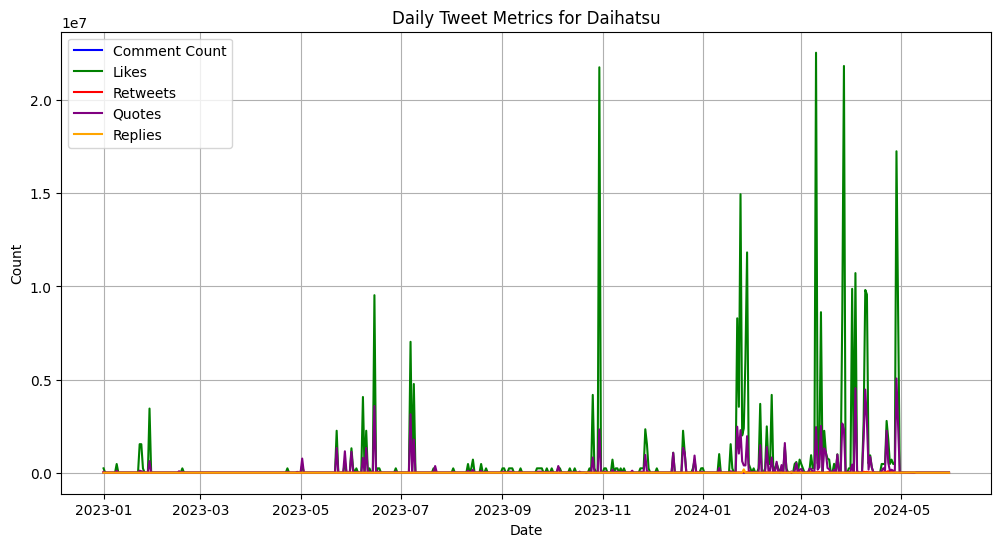

In [5]:
# Tren Temporal Tweet
plt.figure(figsize=(12, 6))

plt.plot(data_harian.index, data_harian['commentcount'], label='Comment Count', color='blue')
plt.plot(data_harian.index, data_harian['likes'], label='Likes', color='green')
plt.plot(data_harian.index, data_harian['retweets'], label='Retweets', color='red')
plt.plot(data_harian.index, data_harian['quotes'], label='Quotes', color='purple')
plt.plot(data_harian.index, data_harian['replies'], label='Replies', color='orange')

plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Daily Tweet Metrics for Daihatsu')
plt.legend()
plt.grid(True)
plt.show()


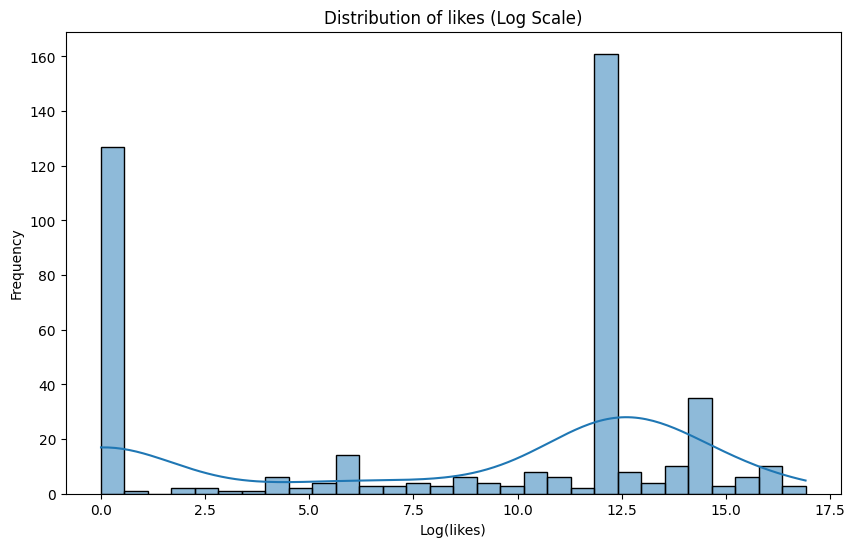

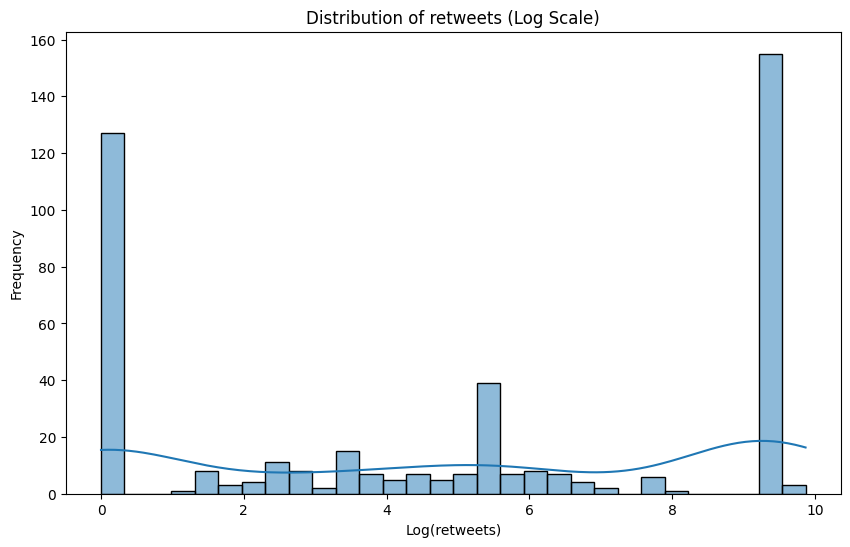

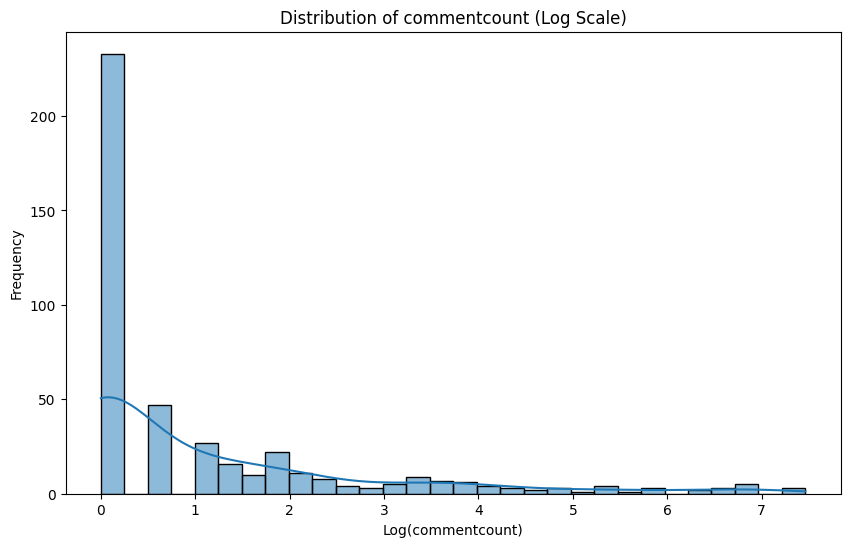

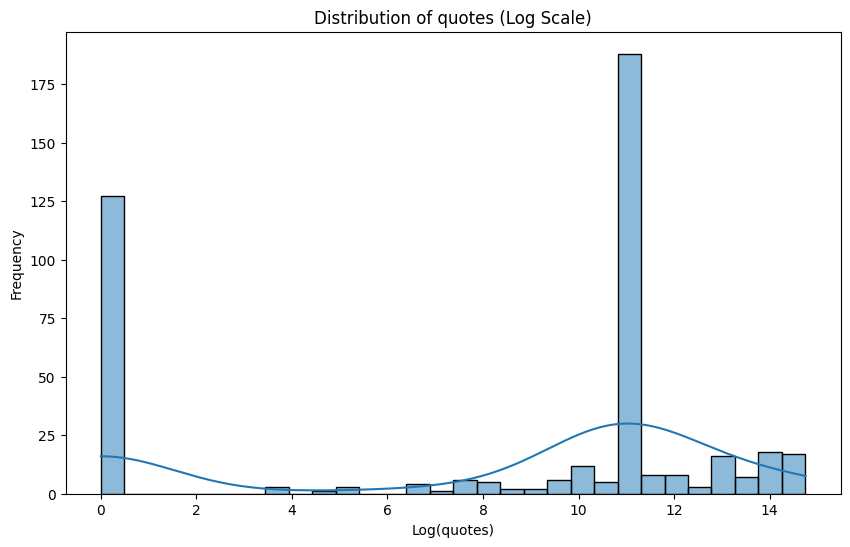

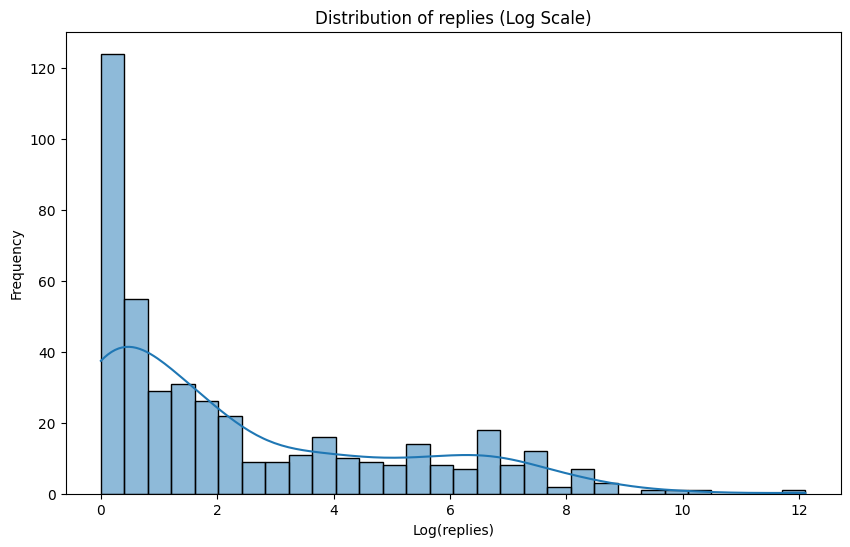

In [6]:
# Plot distribusi data dengan transformasi log
columns = ['likes', 'retweets', 'commentcount', 'quotes', 'replies']
for col in columns:
    plt.figure(figsize=(10, 6))
    log_data = np.log1p(data[col])  # Menggunakan log1p untuk menghindari log(0)
    sns.histplot(log_data, bins=30, kde=True)
    plt.title(f'Distribution of {col} (Log Scale)')
    plt.xlabel(f'Log({col})')
    plt.ylabel('Frequency')
    plt.show()

# **Model LSTM**

In [12]:
data = data_harian[['likes', 'retweets', 'commentcount', 'quotes', 'replies']]

# Transformasi log (tambah 1 untuk menghindari log(0))
data_log_transformed = np.log1p(data)

# Normalisasi data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data_log_transformed)

# Membuat dataset yang sesuai untuk LSTM
def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data) - time_step - 1):
        a = data[i:(i + time_step), :]
        X.append(a)
        Y.append(data[i + time_step, :])
    return np.array(X), np.array(Y)

time_step = 10
X, y = create_dataset(scaled_data, time_step)

# Reshape input menjadi [samples, time steps, features]
X = X.reshape(X.shape[0], X.shape[1], X.shape[2])

# Set seed untuk reproduksibilitas
tf.random.set_seed(1507)

# Hyperparameters
learning_rate = 0.001
epochs = 50
batch_size = 20
k_folds = 5

# Buat direktori untuk menyimpan model
if not os.path.exists('saved_models'):
    os.makedirs('saved_models')

# Cross-validation
kf = KFold(n_splits=k_folds, shuffle=True, random_state=1507)
fold_no = 1

mse_train_scores = []
mse_test_scores = []
all_loss = []
all_val_loss = []

for train_index, test_index in kf.split(X):
    print(f'Fold {fold_no}')

    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Membuat model LSTM
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(time_step, X.shape[2])))
    model.add(Dropout(0.2))  # Menambah dropout layer
    model.add(LSTM(50, return_sequences=False))
    model.add(Dropout(0.2))  # Menambah dropout layer
    model.add(Dense(5))
    model.add(Dense(X.shape[2]))

    # Kompilasi model dengan pengaturan learning rate
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    # Early stopping untuk mencegah overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Melatih model
    history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=0)

    # Simpan model
    model.save(f'saved_models/model_fold_{fold_no}.h5')

    # Evaluasi model
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Menghitung Mean Squared Error
    mse_train = mean_squared_error(y_train, y_train_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)

    print(f'Mean Squared Error (Train): {mse_train}')
    print(f'Mean Squared Error (Test): {mse_test}')

    mse_train_scores.append(mse_train)
    mse_test_scores.append(mse_test)

    # Simpan loss values
    all_loss.append(history.history['loss'])
    all_val_loss.append(history.history['val_loss'])

    fold_no += 1

# Rata-rata dan standar deviasi MSE
mean_mse_train = np.mean(mse_train_scores)
std_mse_train = np.std(mse_train_scores)
mean_mse_test = np.mean(mse_test_scores)
std_mse_test = np.std(mse_test_scores)

print(f'Mean Squared Error (Train) - Mean: {mean_mse_train}, Std: {std_mse_train}')
print(f'Mean Squared Error (Test) - Mean: {mean_mse_test}, Std: {std_mse_test}')

Fold 1


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - 0s 6ms/step
Mean Squared Error (Train): 0.08526280740287234
Mean Squared Error (Test): 0.07814820803457283
Fold 2


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - 0s 6ms/step
Mean Squared Error (Train): 0.07914354612334357
Mean Squared Error (Test): 0.0965774218321859
Fold 3


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - 0s 5ms/step
Mean Squared Error (Train): 0.08014645689522455
Mean Squared Error (Test): 0.07541913406805664
Fold 4


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - 0s 5ms/step
Mean Squared Error (Train): 0.07884858834307959
Mean Squared Error (Test): 0.07354611495012206
Fold 5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - 0s 7ms/step
Mean Squared Error (Train): 0.07888979460333559
Mean Squared Error (Test): 0.07976910442017834
Mean Squared Error (Train) - Mean: 0.08045823867357112, Std: 0.002447876469163443
Mean Squared Error (Test) - Mean: 0.08069199666102315, Std: 0.008228438842008572


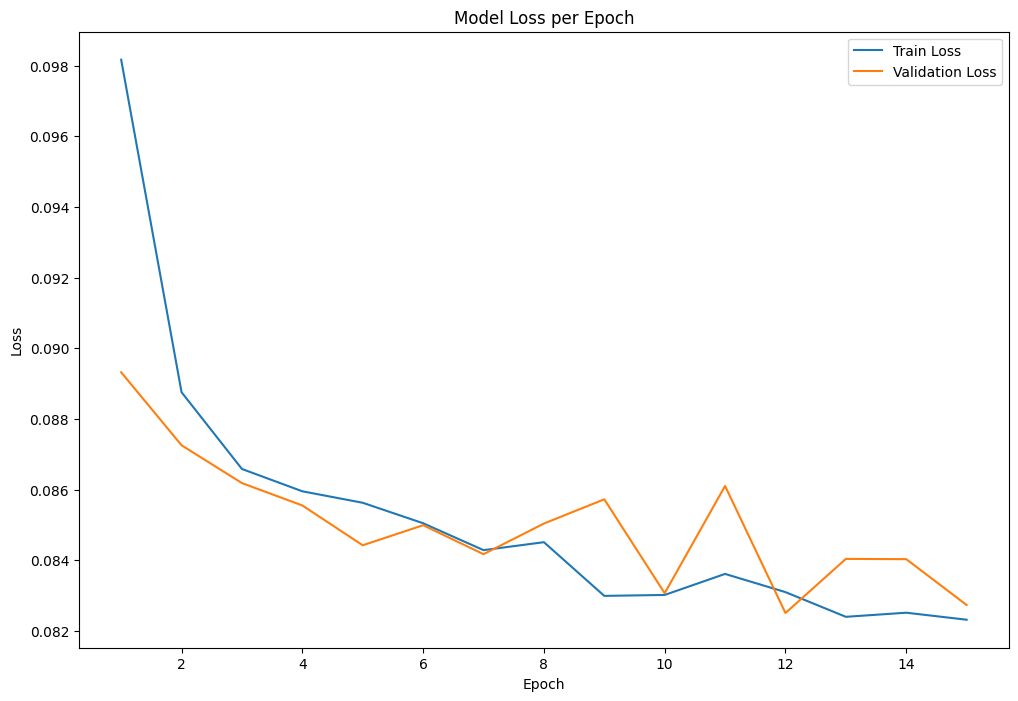

In [13]:
# Plot training & validation loss values berdasarkan epoch
plt.figure(figsize=(12, 8))

# Hitung rata-rata loss dan val_loss untuk setiap epoch
avg_loss = np.mean(np.array([np.pad(loss, (0, epochs - len(loss)), 'constant', constant_values=np.nan) for loss in all_loss]), axis=0)
avg_val_loss = np.mean(np.array([np.pad(val_loss, (0, epochs - len(val_loss)), 'constant', constant_values=np.nan) for val_loss in all_val_loss]), axis=0)

epochs_range = range(1, epochs + 1)
plt.plot(epochs_range, avg_loss, label='Train Loss')
plt.plot(epochs_range, avg_val_loss, label='Validation Loss')

plt.title('Model Loss per Epoch')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

# **Hasil Prediksi**

In [17]:
# Memuat model terakhir yang telah dilatih
model = tf.keras.models.load_model(f'saved_models/model_fold_{k_folds}.h5')

# Memprediksi data dengan model
predictions = model.predict(X)

# Mengubah data prediksi dan data asli kembali ke skala aslinya
predictions_rescaled = scaler.inverse_transform(predictions)
y_rescaled = scaler.inverse_transform(y)

# Membuat DataFrame untuk memudahkan visualisasi
df_results = pd.DataFrame(y_rescaled, columns=['likes', 'retweets', 'commentcount', 'quotes', 'replies'])
df_results['likes_pred'] = predictions_rescaled[:, 0]
df_results['retweets_pred'] = predictions_rescaled[:, 1]
df_results['commentcount_pred'] = predictions_rescaled[:, 2]
df_results['quotes_pred'] = predictions_rescaled[:, 3]
df_results['replies_pred'] = predictions_rescaled[:, 4]

# Menambahkan kolom tanggal
df_results['date'] = data_harian.index[time_step + 1:len(df_results) + time_step + 1]

# Menampilkan beberapa baris pertama untuk melihat hasil
df_results.head()

16/16 [==============================] - 1s 5ms/step


,likes,retweets,commentcount,quotes,replies,likes_pred,retweets_pred,commentcount_pred,quotes_pred,replies_pred,date
0,0.0,0.0,0.0,0.0,0.0,3.895335,2.219489,0.724793,3.362878,1.287650,2023-01-12
1,0.0,0.0,0.0,0.0,0.0,3.171917,1.818768,0.675281,2.698542,1.035253,2023-01-13
2,0.0,0.0,0.0,0.0,0.0,2.739060,1.572832,0.572653,2.359723,1.051253,2023-01-14
3,0.0,0.0,0.0,0.0,0.0,2.384961,1.357273,0.479232,2.075067,1.073166,2023-01-15
4,0.0,0.0,0.0,0.0,0.0,1.993732,1.094652,0.421802,1.702493,0.986027,2023-01-16


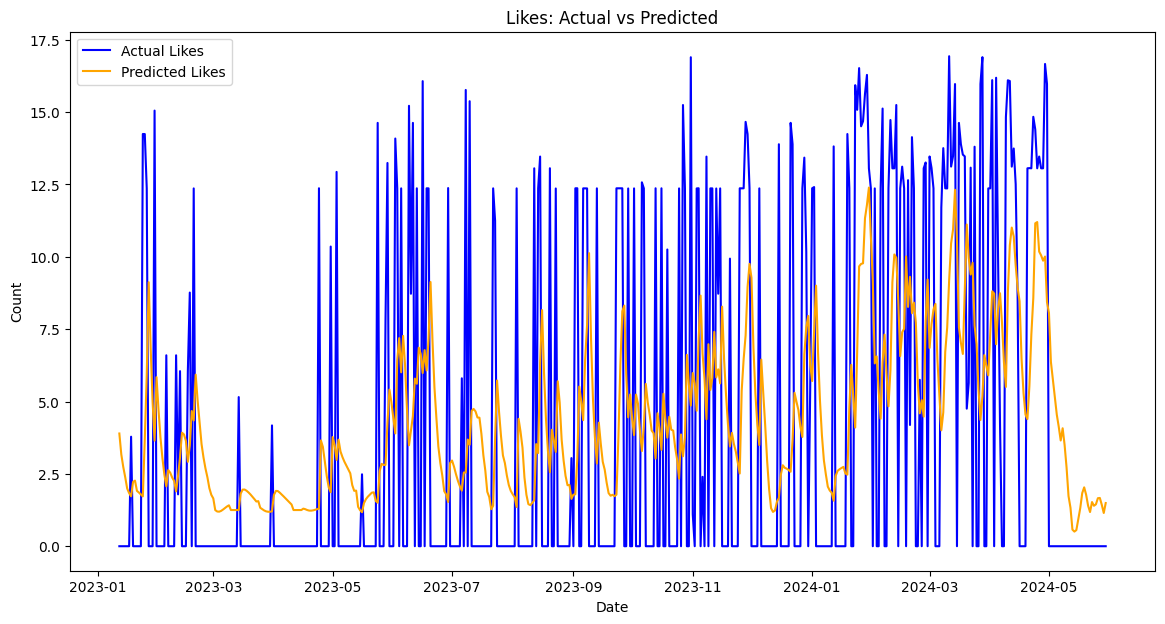

In [18]:
import matplotlib.pyplot as plt

# Mengatur ukuran plot
plt.figure(figsize=(14, 7))

# Plot data asli
plt.plot(df_results['date'], df_results['likes'], label='Actual Likes', color='blue')

# Plot data prediksi
plt.plot(df_results['date'], df_results['likes_pred'], label='Predicted Likes', color='orange')

# Menambahkan judul dan label
plt.title('Likes: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()

# Menampilkan plot
plt.show()


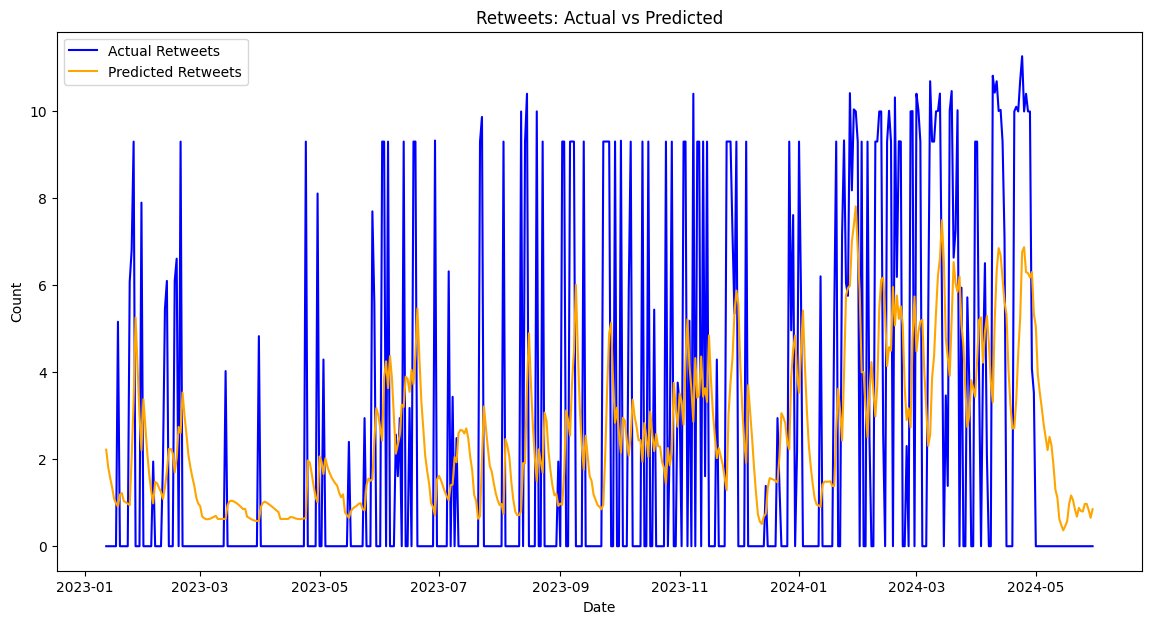

In [19]:
# Plot untuk Retweets
plt.figure(figsize=(14, 7))
plt.plot(df_results['date'], df_results['retweets'], label='Actual Retweets', color='blue')
plt.plot(df_results['date'], df_results['retweets_pred'], label='Predicted Retweets', color='orange')
plt.title('Retweets: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()
plt.show()

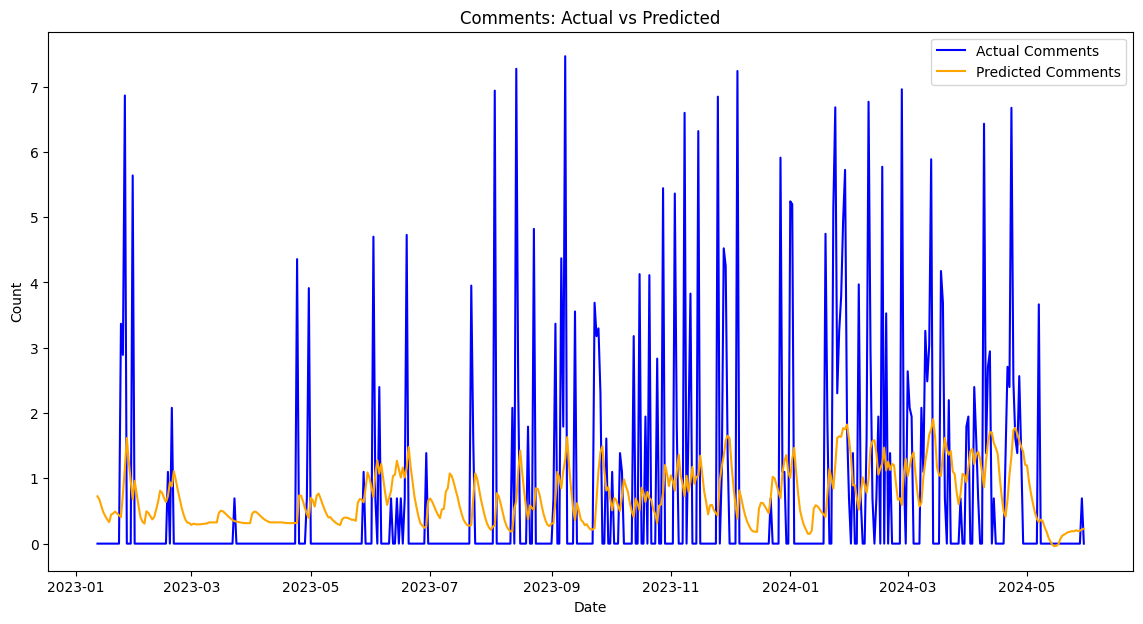

In [20]:
# Plot untuk Comment Count
plt.figure(figsize=(14, 7))
plt.plot(df_results['date'], df_results['commentcount'], label='Actual Comments', color='blue')
plt.plot(df_results['date'], df_results['commentcount_pred'], label='Predicted Comments', color='orange')
plt.title('Comments: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()
plt.show()

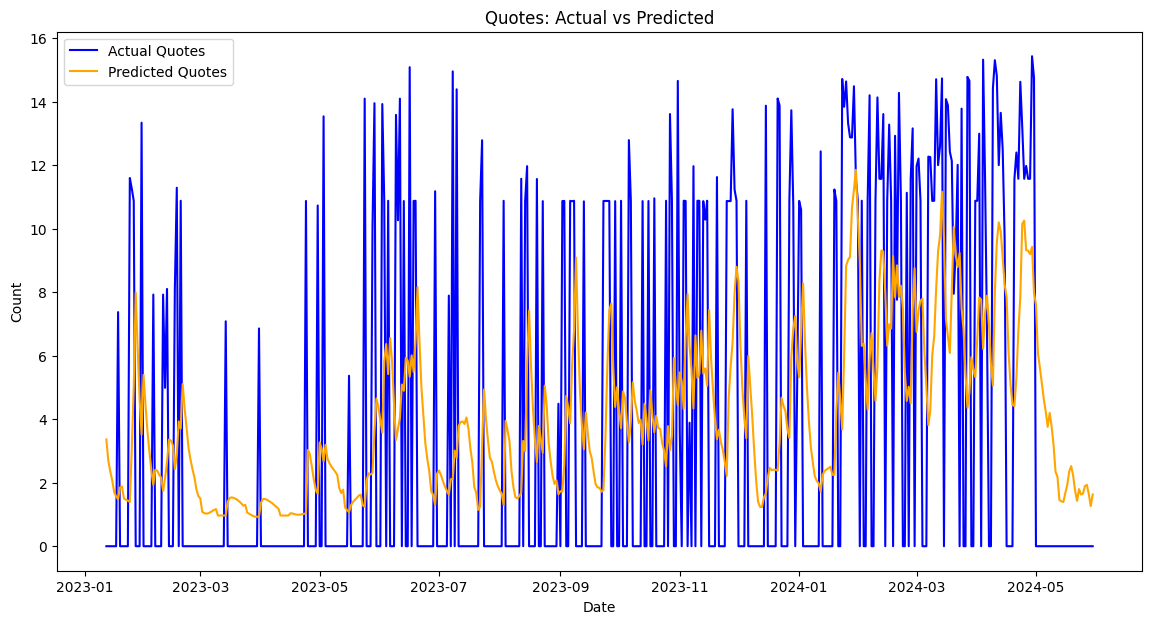

In [21]:
# Plot untuk Quotes
plt.figure(figsize=(14, 7))
plt.plot(df_results['date'], df_results['quotes'], label='Actual Quotes', color='blue')
plt.plot(df_results['date'], df_results['quotes_pred'], label='Predicted Quotes', color='orange')
plt.title('Quotes: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()
plt.show()

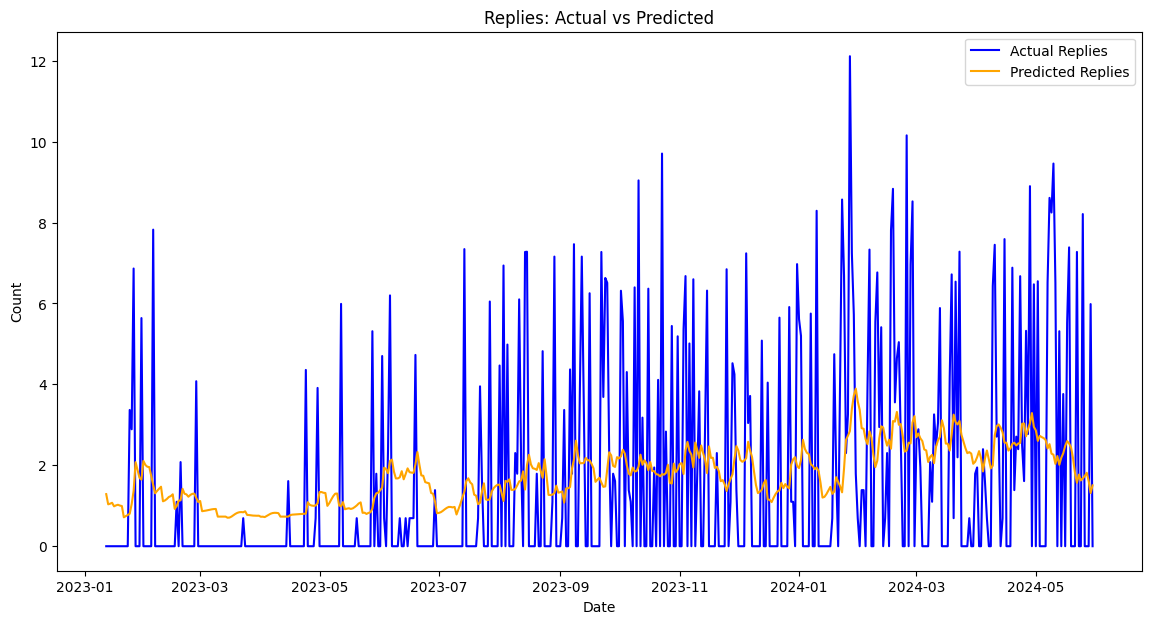

In [22]:
# Plot untuk Replies
plt.figure(figsize=(14, 7))
plt.plot(df_results['date'], df_results['replies'], label='Actual Replies', color='blue')
plt.plot(df_results['date'], df_results['replies_pred'], label='Predicted Replies', color='orange')
plt.title('Replies: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()
plt.show()